In [3]:
"""
My own small code to test my idea of Inception by Google Deep Dream.
Ideas derived from [StarGAN (Choi. et. al)](https://arxiv.org/abs/1711.09020).
I don't know what the outcome will be. Will be surprised if it works.
"""

"\nMy own small code to test my idea of Inception by Google Deep Dream.\nIdeas derived from [StarGAN (Choi. et. al)](https://arxiv.org/abs/1711.09020).\nI don't know what the outcome will be. Will be surprised if it works.\n"

In [4]:
!nvidia-smi

Thu Jun  4 15:40:31 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [0]:
class Translator(nn.Module):
    """
    Translator module:
    Args:
        x : Image Tensor (-1,3,dim,dim)
        y : Image Tensor (-1,3,dim,dim)
    Output:
        Image Tensor (-1,3,dim,dim)
    """
    def __init__(self):
        super().__init__()
        self.down_sample=nn.Sequential(
            nn.Conv2d(in_channels=6,out_channels=64,kernel_size=(7,7),stride=1,padding=3,bias=False),
            nn.InstanceNorm2d(64,affine=True,track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=(4,4),stride=2,padding=1,bias=False),
            nn.InstanceNorm2d(128,affine=True,track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128,out_channels=256,kernel_size=(4,4),stride=2,padding=1,bias=False),
            nn.InstanceNorm2d(256,affine=True,track_running_stats=True),
            nn.ReLU(inplace=True),
        )
        bottle_neck=[]
        for _ in range(2):
            bottle_neck.append(nn.Conv2d(in_channels=256,out_channels=256,kernel_size=(3,3),stride=1,padding=1,bias=False))
            bottle_neck.append(nn.InstanceNorm2d(256,affine=True,track_running_stats=True))
            bottle_neck.append(nn.ReLU(inplace=True))
        self.bottleneck=nn.Sequential(*bottle_neck)
        self.up_sample=nn.Sequential(
            nn.ConvTranspose2d(in_channels=256,out_channels=128,kernel_size=(4,4),stride=2,padding=1,bias=False),
            nn.InstanceNorm2d(128,affine=True,track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=128,out_channels=64,kernel_size=(4,4),stride=2,padding=1,bias=False),
            nn.InstanceNorm2d(64,affine=True,track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_channels=64,out_channels=3,kernel_size=(7,7),stride=1,padding=3,bias=False),
            nn.Tanh(),
        )

    def forward(self,x,y):
        x=torch.cat((x,y),dim=0).unsqueeze(dim=0)
        x=self.down_sample(x)
        x=self.bottleneck(x)
        x=self.up_sample(x)
        return x

In [0]:
# Creating dummy dataset, loads my image and target image again and again.
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torch.utils.data as loader

class Inception(Dataset):
    """
    Literally meaningless class meant for loading the same images again and again
    """
    def __init__(self,image,target,transform):
        """
        Args:
            image (tensor): Image that needs to be translated.
            target (tensor): Not target in the literal sense, but it is the image you wanted to get your image to look like.
            transform (callable, optional): A function/transform that  takes in an PIL image
            and returns a transformed version. E.g, ``transforms.ToTensor``

            Please keep dimensions of image and target same, else it will raise an error.
        """
        self.image=image
        self.target=target
        self.transform=transform
        if self.transform is not None:
            self.image=self.transform(image)
            self.target=self.transform(target)
        
        if self.image.shape!=self.target.shape :
            raise RuntimeError("Dimensions {0} and {1} do not match !".format(self.image.shape,self.target.shape))
    
    def __len__(self):
        return 1
    
    def __getitem__(self,ind):
        """
        Returns the same thing time and again.
        """
        return (self.image,self.target)

In [0]:
from PIL import Image
transform=transforms.Compose([
                              transforms.Resize((128,128)),
                              transforms.ToTensor(),
                              transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5)),
])
image=Image.open('./dp.jpeg')
target=Image.open('./starry_night_van_gogh.jpg')
data=Inception(image=image,target=target,transform=transform)

In [10]:
img,tgt=data[413]
print(img.shape,tgt.shape)

torch.Size([3, 128, 128]) torch.Size([3, 128, 128])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


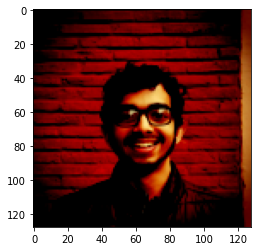

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


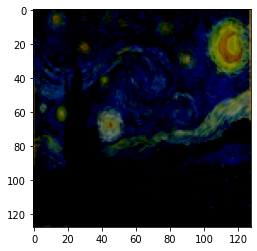

In [11]:
plt.imshow(img.squeeze().numpy().transpose((1,2,0)))
plt.show()
plt.imshow(tgt.squeeze().numpy().transpose((1,2,0)))
plt.show()

In [0]:
data_loader=loader.DataLoader(dataset=data,batch_size=1)

In [126]:
T_=Translator().to(device)
init_samp=T_(img.to(device),tgt.to(device))
init_samp.shape

torch.Size([1, 3, 128, 128])

In [0]:
# I will use the image reconstruction loss as mentioned in the StarGAN paper.
# There will be two image reconstruction losses, one for image, and other for target.
# Objective is to minimize both of them. So that the generated image is similar to both of them.
criterion=nn.L1Loss()
optimT=optim.Adam(T_.parameters(),lr=1e-5)

In [0]:
num_epochs=500
lam_og=1
lam_tgt=100

In [150]:
og_losses=[]
tg_losses=[]
for epoch in range(num_epochs):
    Im,Tg = data[0]
    Im=Im.to(device)
    Tg=Tg.to(device)
    gtd = T_(Im,Tg).squeeze()
    loss_og = criterion(Im,gtd)
    loss_tg = criterion(Tg,gtd)
    loss = lam_og*loss_og + lam_tgt*loss_tg
    loss.backward()
    optimT.step()
    og_losses.append(loss_og.item())
    tg_losses.append(loss_tg.item())
    print("[%d/%d] og_loss:%.4f tg_loss:%.4f"%(epoch+1,num_epochs,loss_og.item(),loss_tg.item()))

[1/500] og_loss:0.1774 tg_loss:0.4713
[2/500] og_loss:0.1774 tg_loss:0.4714
[3/500] og_loss:0.1773 tg_loss:0.4715
[4/500] og_loss:0.1773 tg_loss:0.4716
[5/500] og_loss:0.1772 tg_loss:0.4716
[6/500] og_loss:0.1771 tg_loss:0.4716
[7/500] og_loss:0.1771 tg_loss:0.4715
[8/500] og_loss:0.1770 tg_loss:0.4714
[9/500] og_loss:0.1769 tg_loss:0.4713
[10/500] og_loss:0.1767 tg_loss:0.4710
[11/500] og_loss:0.1766 tg_loss:0.4708
[12/500] og_loss:0.1764 tg_loss:0.4704
[13/500] og_loss:0.1763 tg_loss:0.4700
[14/500] og_loss:0.1761 tg_loss:0.4696
[15/500] og_loss:0.1759 tg_loss:0.4691
[16/500] og_loss:0.1757 tg_loss:0.4685
[17/500] og_loss:0.1755 tg_loss:0.4679
[18/500] og_loss:0.1753 tg_loss:0.4673
[19/500] og_loss:0.1751 tg_loss:0.4666
[20/500] og_loss:0.1749 tg_loss:0.4658
[21/500] og_loss:0.1747 tg_loss:0.4651
[22/500] og_loss:0.1745 tg_loss:0.4642
[23/500] og_loss:0.1743 tg_loss:0.4634
[24/500] og_loss:0.1741 tg_loss:0.4625
[25/500] og_loss:0.1739 tg_loss:0.4616
[26/500] og_loss:0.1737 tg_loss:0.

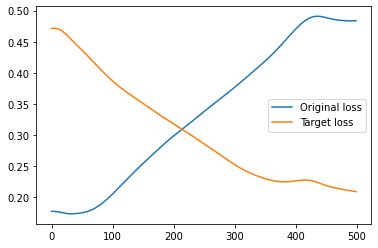

In [151]:
plt.plot(og_losses,label='Original loss')
plt.plot(tg_losses,label='Target loss')
plt.legend()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


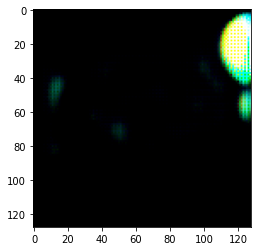

In [152]:
plt.imshow(T_(img.to(device),tgt.to(device)).squeeze().cpu().detach().numpy().transpose((1,2,0)))
plt.show()